# imports

In [1]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

Using TensorFlow backend.


# how many breeds and pictures we have

In [2]:
breed_list = os.listdir("../input/stanford-dogs-dataset/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("../input/stanford-dogs-dataset/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


# label strings and numbers mapping

In [3]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

# show some pictures

In [4]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "../input/stanford-dogs-dataset/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02104365-schipperke


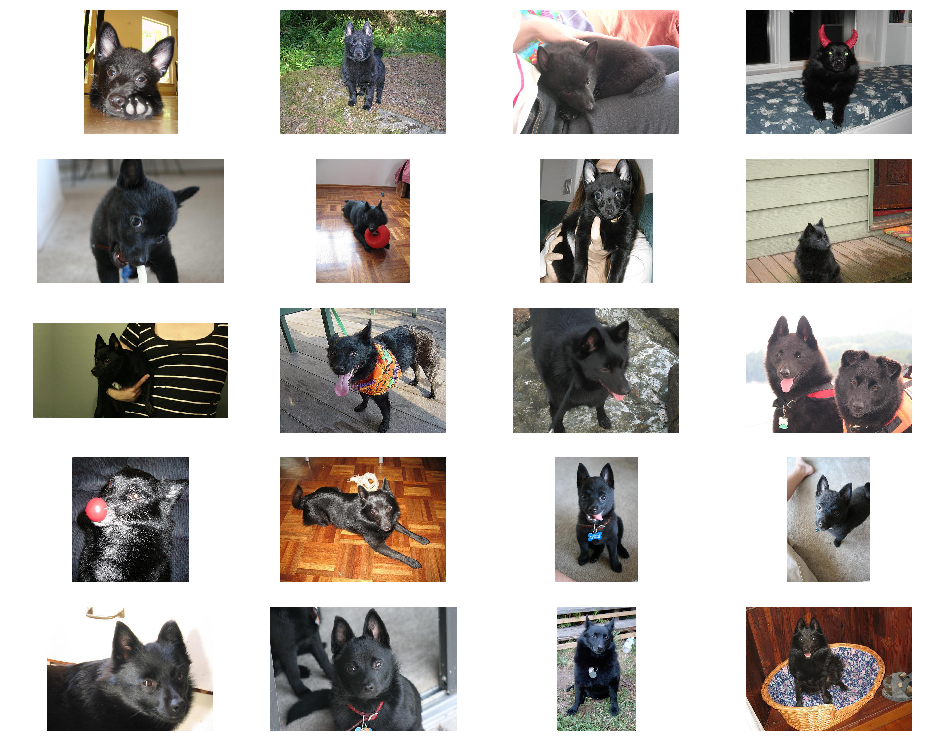

In [5]:
print(breed_list[5])
show_dir_images(breed_list[5], 20)

# crop and save pictures

In [6]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('../input/stanford-dogs-dataset/annotations/Annotation/{}'.format(breed)):
        img = Image.open('../input/stanford-dogs-dataset/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('../input/stanford-dogs-dataset/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
CPU times: user 1min 40s, sys: 4.62 s, total: 1min 45s
Wall time: 5min 54s


# prepare X and y

In [7]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

# image generator with augment

In [8]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

# train test split

In [9]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

# keras pretrain densenet121 model

In [10]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="../input/densenet-keras/DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# only train our last 6 layers

In [11]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [12]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [13]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
547/547 [==============================] - 89s 162ms/step - loss: 3.8118 - acc: 0.1230 - val_loss: 1.7391 - val_acc: 0.4749
Epoch 2/20
547/547 [==============================] - 81s 148ms/step - loss: 2.7057 - acc: 0.2790 - val_loss: 1.4067 - val_acc: 0.5718
Epoch 3/20
547/547 [==============================] - 80s 146ms/step - loss: 2.4516 - acc: 0.3381 - val_loss: 1.2728 - val_acc: 0.6035
Epoch 4/20
547/547 [==============================] - 84s 154ms/step - loss: 2.3117 - acc: 0.3652 - val_loss: 1.2576 - val_acc: 0.5954
Epoch 5/20
547/547 [==============================] - 81s 148ms/step - loss: 2.2416 - acc: 0.3885 - val_loss: 1.1624 - val_acc: 0.6411
Epoch 6/20
547/547 [==============================] - 80s 145ms/step - loss: 2.1478 - acc: 0.4101 - val_loss: 1.1501 - val_acc: 0.6414
Epoch 7/20
547/547 [==============================] - 80s 146ms/step - loss: 2.1286 - acc: 0.4139 - val_loss: 1.1404 - val_acc: 0.6443
Epoch 8

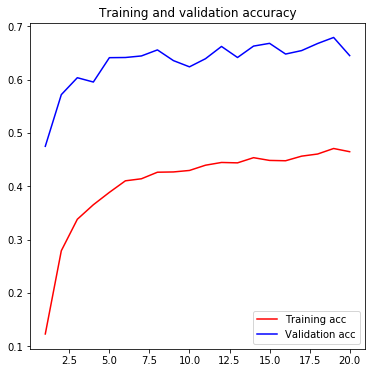

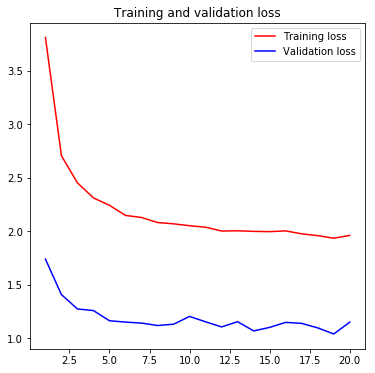

In [14]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

# now train all layers

In [15]:
for layer in model.layers[:]:
    layer.trainable = True

In [16]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [17]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - 82s 150ms/step - loss: 1.9431 - acc: 0.4707 - val_loss: 1.1084 - val_acc: 0.6618

Epoch 00001: val_acc improved from -inf to 0.66181, saving model to dog_breed_classifier_model.h5
Epoch 2/20
547/547 [==============================] - 81s 148ms/step - loss: 1.9360 - acc: 0.4684 - val_loss: 1.0432 - val_acc: 0.6744

Epoch 00002: val_acc improved from 0.66181 to 0.67444, saving model to dog_breed_classifier_model.h5
Epoch 3/20
547/547 [==============================] - 81s 149ms/step - loss: 1.9327 - acc: 0.4671 - val_loss: 1.0704 - val_acc: 0.6777

Epoch 00003: val_acc improved from 0.67444 to 0.67768, saving model to dog_breed_classifier_model.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/20
547/547 [==============================] - 79s 145ms/step - loss: 1.7576 - acc: 0.5074 - val_loss: 0.9828 - val_acc: 0.6978

Epoch 00004: val_acc improved from 0.67768 to 0.69776, saving model to dog

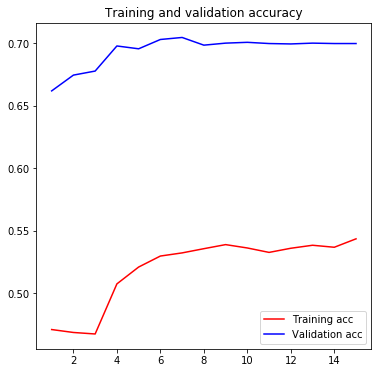

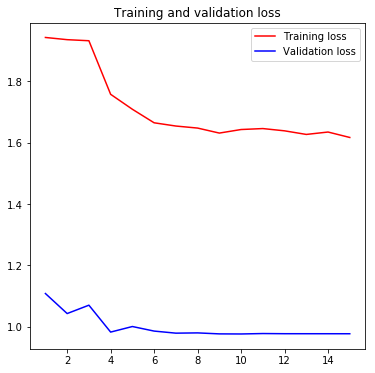

In [18]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [19]:
print(max(val_acc))

0.7045675413408518


# predict new images

download some dog images from pixabay for testing

In [20]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

64.00% 	 malinois
11.09% 	 German_shepherd
8.41% 	 dhole
8.15% 	 dingo
5.28% 	 kelpie


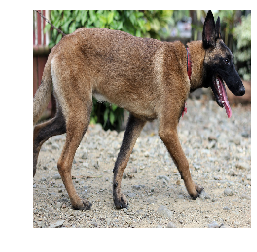

In [21]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")

97.16% 	 Pembroke
2.74% 	 Cardigan
0.06% 	 dingo
0.02% 	 basenji
0.01% 	 Eskimo_dog


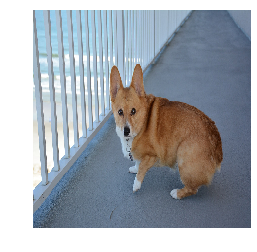

In [22]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

79.83% 	 Chihuahua
17.83% 	 toy_terrier
1.06% 	 miniature_pinscher
0.70% 	 basenji
0.25% 	 Pembroke


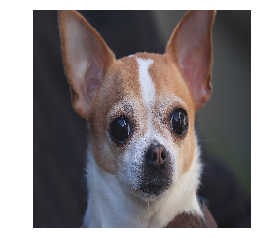

In [23]:
download_and_predict("https://cdn.pixabay.com/photo/2019/02/24/20/15/chihuahua-4018429_1280.jpg",
                     "test_3.jpg")

32.36% 	 redbone
15.87% 	 Rhodesian_ridgeback
11.01% 	 bloodhound
8.92% 	 English_foxhound
7.08% 	 vizsla


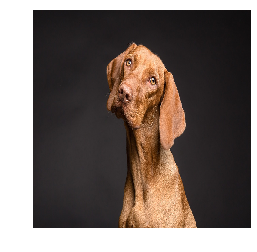

In [24]:
download_and_predict("https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
                     "test_4.jpg")

77.41% 	 Labrador_retriever
19.47% 	 golden_retriever
1.71% 	 Chesapeake_Bay_retriever
0.86% 	 Rhodesian_ridgeback
0.11% 	 redbone


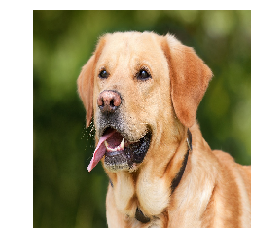

In [25]:
download_and_predict("https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_1280.jpg",
                     "test_5.jpg")

# cleaning

In [26]:
!rm -rf data/* 

In [27]:
!rm -f test_*.jpg